##Libraries

In [1]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5
HEAD is now at 064365d Update parse_opt() in export.py to work as in train.py (#10789)


In [2]:
!pip install -qr requirements.txt
import torch

from IPython.display import Image, clear_output
from utils.downloads import attempt_download

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.1.0+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [4]:
%cat {dataset.location}/data.yaml

names:
- enemy
- enemy-head
nc: 2
roboflow:
  license: Public Domain
  project: halo-myn21
  url: https://universe.roboflow.com/cnn-nwosf/halo-myn21/dataset/3
  version: 3
  workspace: cnn-nwosf
test: ../test/images
train: halo-3/train/images
val: halo-3/valid/images


##Model Preparation

In [5]:
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [6]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [7]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [8]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml


nc: {num_classes}
depth_multiple: 0.33
width_multiple: 0.50


anchors:
  - [10,13, 16,30, 33,23]
  - [30,61, 62,45, 59,119]
  - [116,90, 156,198, 373,326]


backbone:

  [[-1, 1, Focus, [64, 3]],
   [-1, 1, Conv, [128, 3, 2]],
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],
  ]


head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],
   [-1, 3, BottleneckCSP, [512, False]],

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],
   [-1, 3, BottleneckCSP, [256, False]],

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],
   [-1, 3, BottleneckCSP, [512, False]],

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],
   [-1, 3, BottleneckCSP, [1024, False]],

   [[17, 20, 23], 1, Detect, [nc, anchors]],
  ]

##Model Train

In [11]:
%%time
%cd /content/yolov5/
!python train.py --img 640 --batch 32 --epochs 15 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache

/content/yolov5
2023-12-25 17:28:05.006731: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-25 17:28:05.006789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-25 17:28:05.008309: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-25 17:28:06.096947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=yolov5s.pt, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/halo-3/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False,

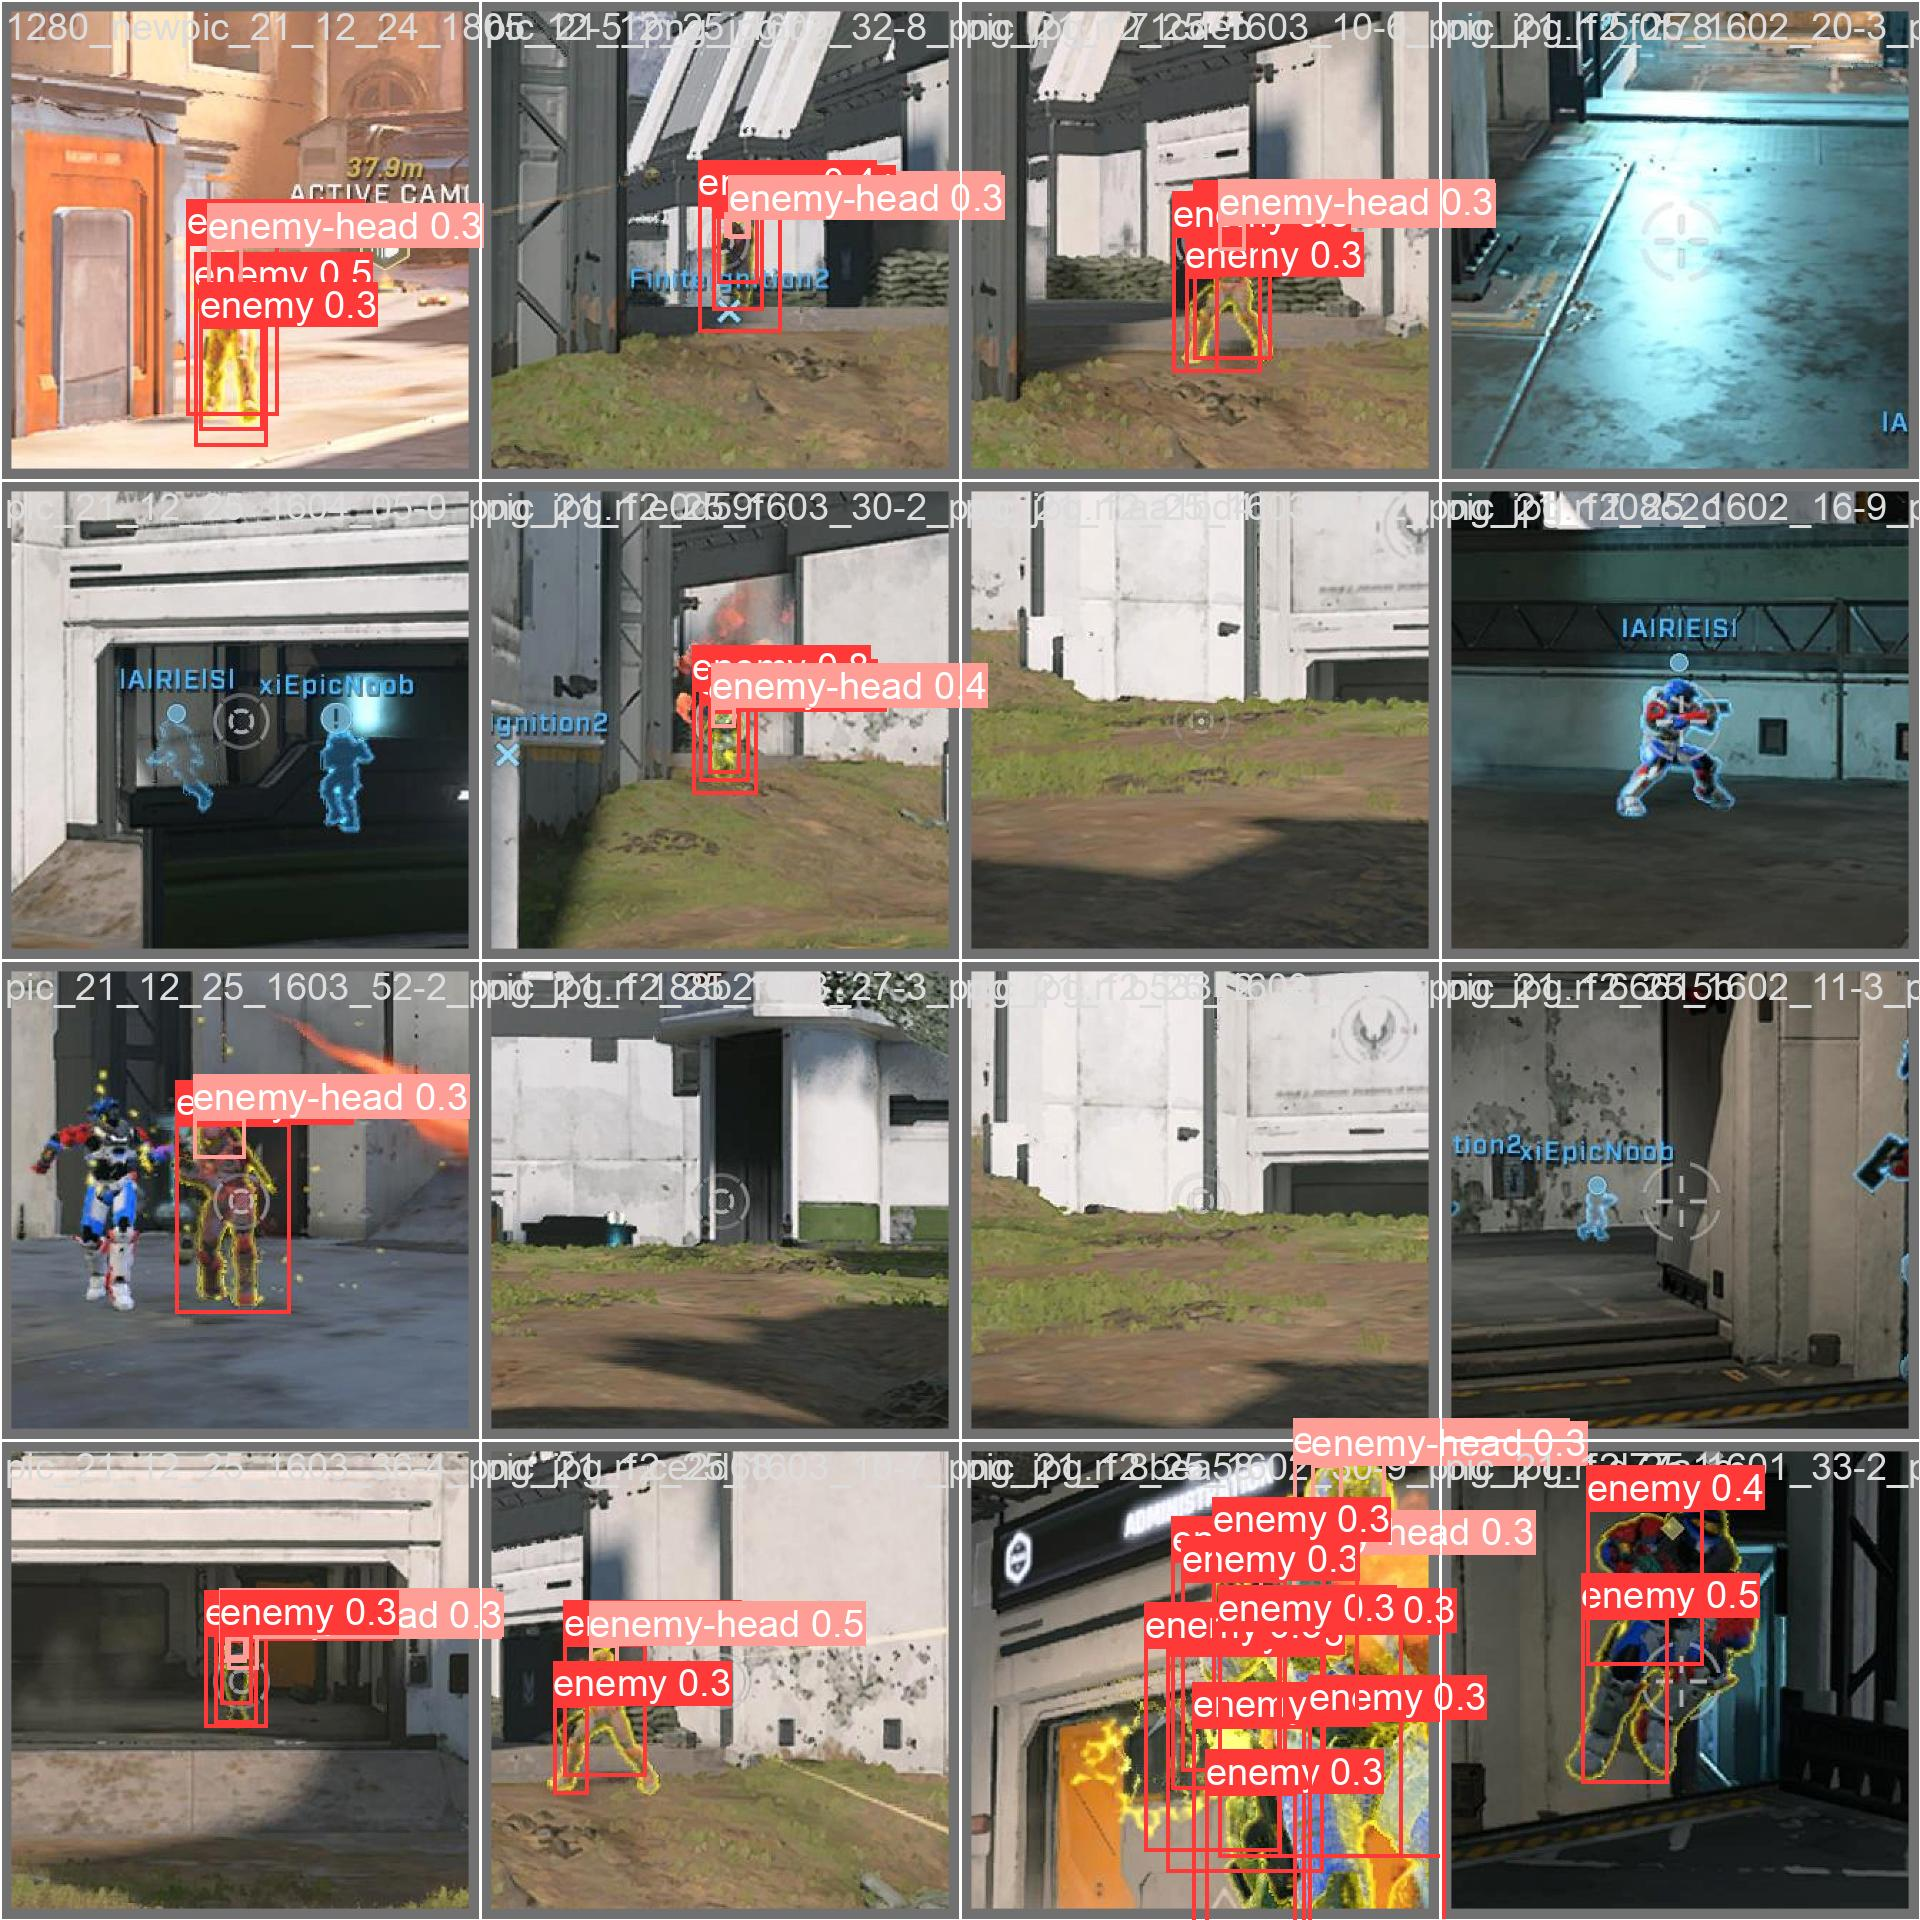

In [12]:
Image(filename='/content/yolov5/runs/train/yolov5s_results3/val_batch0_pred.jpg', width=900)

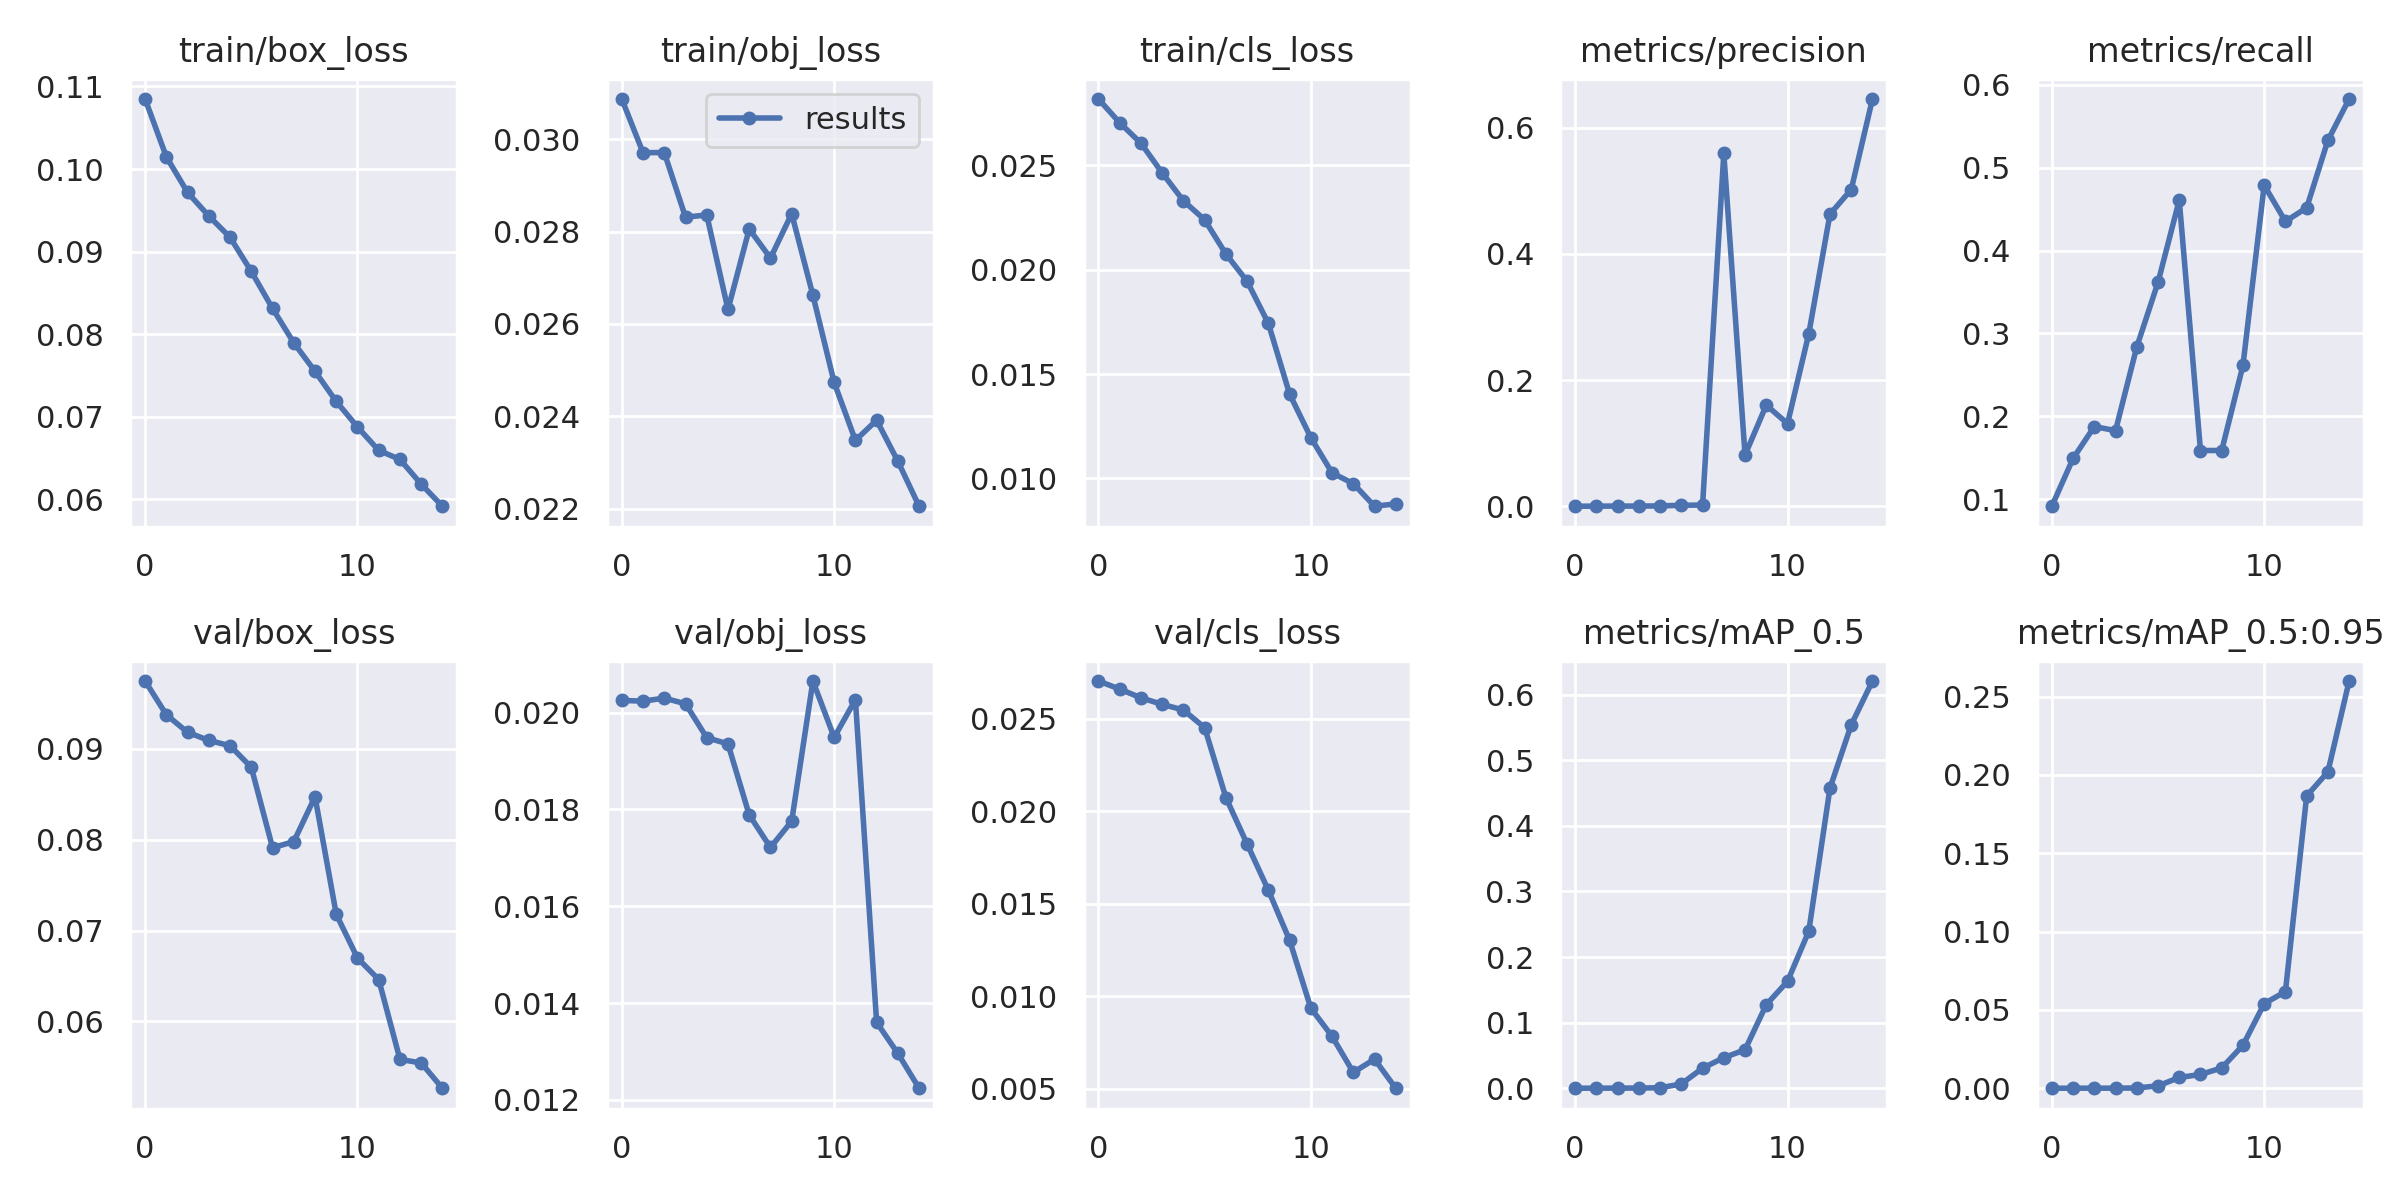

In [18]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/train/yolov5s_results3/results.png'):
    display(Image(filename=imageName))
    print("\n")

##Detection

In [15]:
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results2/weights/best.pt --img 640 --conf 0.7 --source /content/yolov5/halo-3/test/images

/content/yolov5
detect: weights=['/content/yolov5/runs/train/yolov5s_results2/weights/best.pt'], source=/content/yolov5/halo-3/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.7, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7249215 parameters, 0 gradients
image 1/112 /content/yolov5/halo-3/test/images/1280_newpic_21_12_24_1804_30-4_png_jpg.rf.1ffea1fe011488e3f79159f8c46043a1.jpg: 640x640 (no detections), 12.5ms
image 2/112 /content/yolov5/halo-3/test/images/1280_newpic_21_12_24_1804_30-6_png_jpg.rf.d7f2d14e096cf35abbf0041c1be06f7b.jpg: 640x64

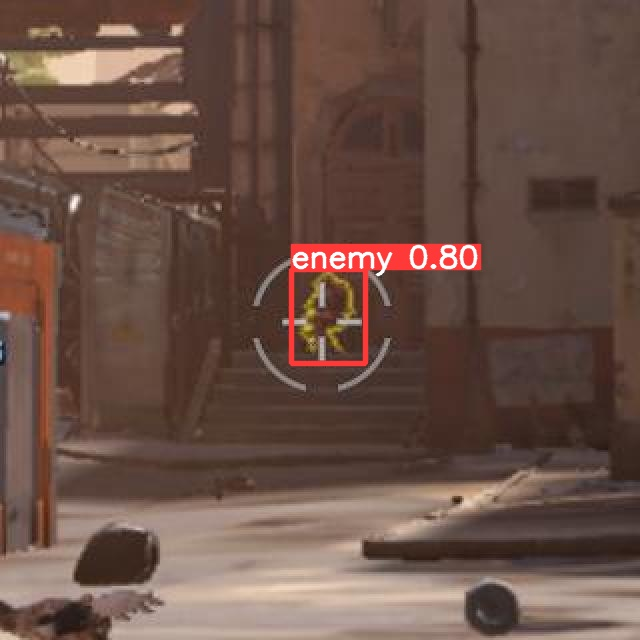

In [21]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/1280_newpic_21_12_24_1805_55-1_png_jpg.rf.143c926a9fa00538590bcf8a2a5d3923.jpg'):
    display(Image(filename=imageName))
    print("\n")